***
Title     : `00-main.ipynb`<br>
Author    : Paul Covert<br>
Date      : 2025-02-15<br>
Version   : 1.0.0<br>
URL       : <br>
Aim       : Jupyter notebook for exploration of environmental data.  Use `00-main.py` for production calculations and visualization.
***

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import adcp
import tcm

In [26]:
# Define root data path
DATA_RAW = Path("../data")

Determine start and stop times of TCM traces.  The sensors were not stopped immediately upon retrieval, so there is a long period (days) at the end of each trace that needs to be trimmed.

In [27]:
# Set the time slices
ANSE_DES_PILOTES_SLICE = slice(
    pd.to_datetime("2022-07-01T00:00:00"), 
    pd.to_datetime("2022-11-06T16:00:00")
)
LA_BALEINE_SLICE = slice(
    pd.to_datetime("2022-07-01T00:00:00"),
    pd.to_datetime("2022-11-06T17:30:00")
)
ILE_AUX_LIEVRES_1_SLICE = slice(
    pd.to_datetime("2022-06-01T00:00:00"),
    pd.to_datetime("2022-11-08T17:30:00")
)
ILE_AUX_LIEVRES_2_SLICE = slice(
    pd.to_datetime("2022-06-01T00:00:00"),
    pd.to_datetime("2022-11-08T16:30:00")
)

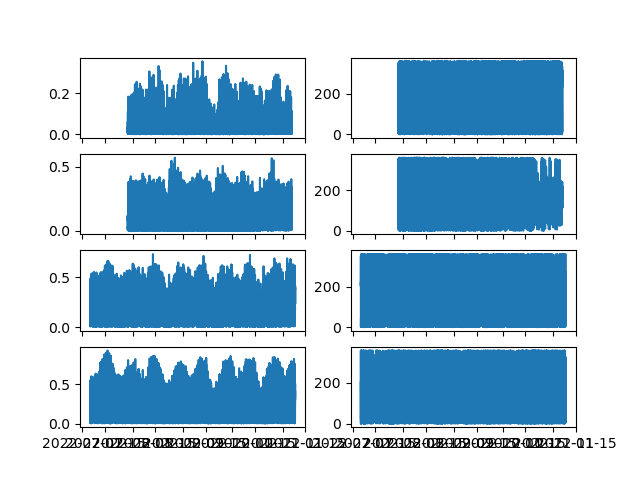

In [28]:
# Plot speed and direction for Quebec sensors

%matplotlib widget
fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True)

df_tcm = tcm.read_csv(tcm.paths.get("anse_des_pilotes", root=DATA_RAW))
df_tcm = df_tcm.loc[ANSE_DES_PILOTES_SLICE]
ax[0][0].plot(df_tcm["speed"])
ax[0][1].plot(df_tcm["dir"])

df_tcm = tcm.read_csv(tcm.paths.get("la_baleine", root=DATA_RAW))
df_tcm = df_tcm.loc[LA_BALEINE_SLICE]
ax[1][0].plot(df_tcm["speed"])
ax[1][1].plot(df_tcm["dir"])

df_tcm = tcm.read_csv(tcm.paths.get("ile_aux_lievres_1", root=DATA_RAW))
df_tcm = df_tcm.loc[ILE_AUX_LIEVRES_1_SLICE]
ax[2][0].plot(df_tcm["speed"])
ax[2][1].plot(df_tcm["dir"])

df_tcm = tcm.read_csv(tcm.paths.get("ile_aux_lievres_2", root=DATA_RAW))
df_tcm = df_tcm.loc[ILE_AUX_LIEVRES_2_SLICE]
ax[3][0].plot(df_tcm["speed"])
ax[3][1].plot(df_tcm["dir"])

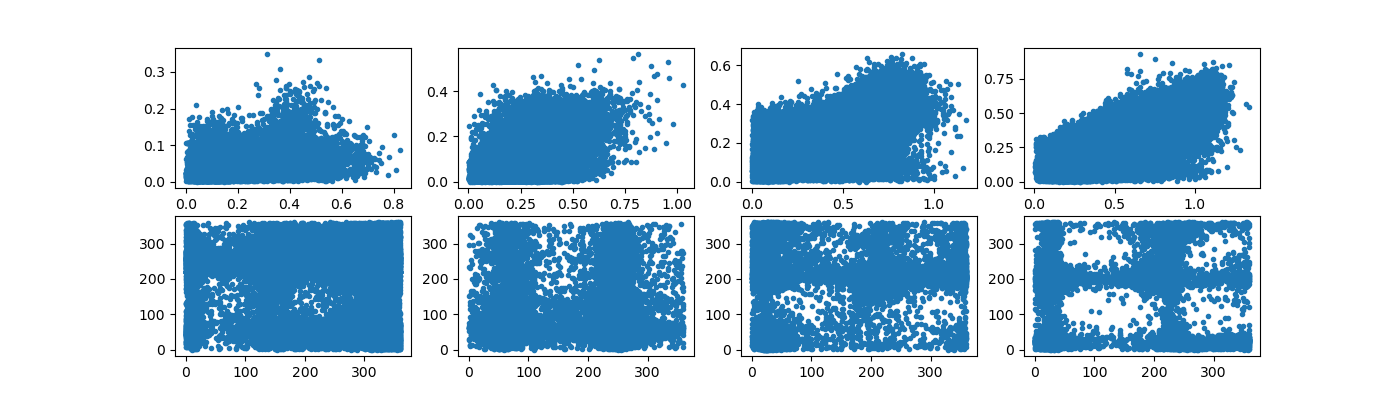

In [38]:
# Explore Quebec ADCP vs TCM currents
ALL_ADCP = adcp.paths.get("qc", root=DATA_RAW)
ALL_TCM = tcm.paths.get("qc", root=DATA_RAW)
tcm_slices = [ANSE_DES_PILOTES_SLICE, LA_BALEINE_SLICE, ILE_AUX_LIEVRES_1_SLICE, ILE_AUX_LIEVRES_2_SLICE]

%matplotlib widget
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14,4))

for i in range(4):
    
    # Load adcp and tcm files
    ds_adcp = adcp.open_dataset(ALL_ADCP[i])
    df_tcm = tcm.read_csv(ALL_TCM[i])
    df_tcm = df_tcm.loc[tcm_slices[i]]

    # Estimate adcp altitude, assuming transducer is ~0.5m above bottom
    ds_adcp["altitude"] = (ds_adcp["xducer_depth"] + 0.5) - np.max(ds_adcp["depth"])

    # Select deepest adcp current measurement
    ds_adcp = ds_adcp.sel(depth=np.max(ds_adcp["depth"]))
    ds_adcp = ds_adcp.dropna("time")
    df_adcp = ds_adcp.to_pandas()

    # Interpolate tcm speed and direction onto adcp timeseries
    # Note: tcm measures current once per minute, while adcp current is once
    #       every 5 minutes
    df_adcp["speed_tcm"] = np.interp(df_adcp.index, df_tcm.index, df_tcm["speed"])
    df_adcp["dir_tcm"] = np.interp(df_adcp.index, df_tcm.index, df_tcm["dir"])

    # Select measures where altitude < 5m
    #df_adcp = df_adcp[df_adcp["altitude"]<=3]
    
    # Plot speed and dir
    ax[0][i].plot(df_adcp["speed"], df_adcp["speed_tcm"], '.')
    ax[1][i].plot(df_adcp["dir"], df_adcp["dir_tcm"], '.')